## Freeverb V2
#### Annie Chu
Implementing Freeverb algorithms again

Last Updated: Oct 30, 2021

UPDATES - reverb sounds scaled back and much better now!

1) fixed lp_comb difference eq

2) cleaned up freeverb class code 

    - added consolidated L vs R reverb def via switch case
    
    - added functions: 1) normalizing 2) mixing 3) reglueing L/R outputs into one sig_out
    
    - added some test functions
 
3) added scaling to delays based on input 

    - Added linear interpolation into the filters
    
    
NEXT STEPS
1) add in design element for reverb parameter inputs (ie what size room?, what material?,etc)

2) move filter print functions into test functions

3) comments for each block
   

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import simpleaudio as sa
from matplotlib.pyplot import figure
import math

## Building Freeverb Filter Blocks

Feedback Comb & All Pass Filters via Difference Equations

In [2]:
# creating feedback comb filter
def comb(x_n, g, d):
    # x_n is numpy array of initial samples
    y_n = np.zeros(len(x_n));
    y_n0 = np.zeros(len(x_n)); 
    y_n1 = np.zeros(len(x_n));
    if type(d) == int:
        for i in range(len(x_n)):
            if i-d < 0:
                y_n[i] = x_n[i]
            else:
                y_n[i] = x_n[i] + g*y_n[i-d]
    elif type(d) == float:
        for i in range(len(x_n)):
            down = math.floor(i-d)
            up = math.ceil(i-d)
            y_mid = y_n[down] + (((y_n[up] - y_n[down])/(up - down)) * ((i-d) - down)) 
            if i-d < 0:
                y_n[i] = x_n[i]
            else:
                y_n[i] = x_n[i] + g*y_mid
                
            
                print(F" n = {i} | d = {d} | n-d = {i-d}")
#                 print(F" Round Down {i-1.5} : {down} | Round Up {i-1.5} : {up}")
#                 print(F" Y({down}): {y_n[down]} | Y({up}): {y_n[up]}")
#                 print(F" Y({i-1.5}) = {0.5*(y_n[up] + y_n[down])}")
#                 print('-----')

    return y_n

In [3]:
#testing comb
x0 = np.array([1.0, 0.5, 0.25, 2, 3, 4])

x = comb(x0, 0.5, 1)
y = comb(x0, 0.5, 2)

z = comb(x0, 0.5, 1.5)

print(x)
print(y)
print(z)

 n = 2 | d = 1.5 | n-d = 0.5
 n = 3 | d = 1.5 | n-d = 1.5
 n = 4 | d = 1.5 | n-d = 2.5
 n = 5 | d = 1.5 | n-d = 3.5
[1.      1.      0.75    2.375   4.1875  6.09375]
[1.    0.5   0.75  2.25  3.375 5.125]
[1.         0.5        0.625      2.28125    3.7265625  5.50195312]


In [4]:
def allpass(x_n, g, d):
    # x_n is numpy array of initial samples
    y_n = np.zeros(len(x_n));
    
    if type(d) == int:
        for i in range(len(x_n)):
            if i-d < 0:
                y_n[i] = g*x_n[i]
            else:
                y_n[i] = g*x_n[i] + x_n[i-d] - g*y_n[i-d]
            
    elif type(d) == float: 
        for i in range(len(x_n)):
            down = math.floor(i-d)
            up = math.ceil(i-d)
            
            if i-d < 0:
                y_n[i] = g*x_n[i]

            else:
                x_mid = x_n[down] + ((x_n[up] - x_n[down]) * ((i-d) - down))
                y_mid =  y_n[down] + ((y_n[up] - y_n[down]) * ((i-d) - down))
                y_n[i] = g*x_n[i] + x_mid - g*y_mid

    return y_n

In [5]:
#testing all pass TODO: TEST THIS
x3 = np.array([1.0, 0.5, 0.25, 2, 3, 4])

print(allpass(x3, 0.5, 1))
print(allpass(x3, 0.5, 2))

print(allpass(x3, 0.5, 3.4))

[0.5      1.       0.125    1.1875   2.90625  3.546875]
[0.5    0.25   0.875  1.375  1.3125 3.3125]
[0.5    0.25   0.125  1.     2.025  2.2625]


In [6]:
def lp_comb(x_n, g, d, sg):
    """
    # x_n -> numpy array of initial samples
    # g -> damp = initialdamp*scaledamp
        `damping'' parameter controls how rapidly T60 shortens as a function of increasing frequency.
        
    # sg -> lowpass scale factor = room size = initialroom*scaleroom + offsetroom
        - RoomSize (range: 0 to 1) -- controls the length of the reverb, a higher value means longer reverb
        - The feedback variable f (sg here) mainly determines reverberation time at low-frequencies 
            at which the feedback lowpass has negligible effect. 
        The feedback lowpass causes the reverberation time to decrease with frequency, which is natural.
        room size'' parameter can be interpreted as setting the low-frequency T60 (time to decay 60 dB) 
    
    https://ccrma.stanford.edu/~jos/Reverb/Freeverb_Parameters.html
    """
    y_n = np.zeros(len(x_n));
    
    if type(d) == int:
#         print("y_n[i] = x_n[i] - g*x_n[i-1] + g*y_n[i-1] + sg*(1-g)*y_n[i-d]")
        for i in range(len(x_n)):
            if i-d < 0 and i-1 < 0:
                y_n[i] = x_n[i]
#                 print(F"C1: I = {i} D = {d} | I-D = NEG = {i-d} | i-1 = NEG = {i-1}")
#                 print(F"CHECKING... y_n[{i}] = {y_n[i]} SHOULD = {x_n[i]}")
            elif i-d < 0 and i-1 >= 0:
                y_n[i] = x_n[i] - g*x_n[i-1] + g*y_n[i-1]
#                 print(F"C2: I = {i}  D = {d}| I-D = NEG = {i-d} | i-1 = >= 0 = {i-1}")
#                 print(F"CHECKING...y_n[{i}] =  {y_n[i]} SHOULD = {x_n[i]} - 0.5*{x_n[i-1]} + 0.5*{y_n[i-1]}")
            else:
                y_n[i] = x_n[i] - g*x_n[i-1] + g*y_n[i-1] + sg*(1-g)*y_n[i-d]
#                 print(F"C3: I = {i}  D = {d}| I-D = pos = {i-d} | i-1 = pos = {i-1}")
#                 print(F"CHECKING...y_n[{i}] =  {y_n[i]} SHOULD = {x_n[i]} - 0.5*{x_n[i-1]} + 0.5*{y_n[i-1]}+ 1*0.5*{y_n[i-d]}")
        
    elif type(d) == float:
        for i in range(len(x_n)):            
            if i-d < 0 and i-1 < 0:
#                 print("case 0: y_n[i] = x_n[i] ")
                y_n[i] = x_n[i]
            elif i-d < 0 and i-1 > 0:
#                 print("case 1: y_n[i] = x_n[i] - g*x_1 + g*y_1")
                down1 = math.floor(i-1)
                up1 = math.ceil(i-1) 
                x_1 = 0.5*(x_n[up1] + x_n[down1])
                y_1 = 0.5*(y_n[up1] + y_n[down1])
                x_1 = x_n[down1] + ((x_n[up1] - x_n[down1]) * ((i-1) - down1))
                y_1 =  y_n[down1] + ((y_n[up1] - y_n[down1]) * ((i-1) - down1)) 
                y_n[i] = x_n[i] - g*x_1 + g*y_1
#                 print(f"y_n[{i}] = {x_n[i]} - {g*x_1} + {g*y_1}")
            elif i-d >=0: 
#                 print("case 2: both pos, ")
                down = math.floor(i-d)
                up = math.ceil(i-d)
                down1 = math.floor(i-1)
                up1 = math.ceil(i-1) 
                x_1 = x_n[down1] + ((x_n[up1] - x_n[down1]) * ((i-1) - down1))
                y_1 =  y_n[down1] + ((y_n[up1] - y_n[down1]) * ((i-1) - down1)) 
                
                x_mid = x_n[down] + ((x_n[up] - x_n[down]) * ((i-d) - down))
#                 print(f"x_mid[{i}] = {x_mid} = {x_n[down]} + (({x_n[up]} - {x_n[down]}) * (({i-d}) - {down})")

                y_mid =  y_n[down] + ((y_n[up] - y_n[down]) * ((i-d) - down)) 
#                 print(f"y_mid[{i}] = {y_mid} = {y_n[down]} + (({y_n[up]} - {y_n[down]})) * (({i-d}) - {down})")
                
                
                y_n[i] = x_n[i] - g*x_1 + g*y_1 + sg*(1-g)*y_mid
#                 print(f" y_n[{i}] = {y_n[i]} = {x_n[i]} - g*{x_1} + g*{y_1} + sg*(1-g)*{y_mid}")
#                 print(y_n)
        
    return y_n

In [7]:
#testing lp_comb
x1 = np.array([1.0, 0.5, 0.25, 2, 3, 4])

y1 = lp_comb(x1, 0.5, 2.22, 0.1)
print(y1)

[1.       0.       0.       1.886    2.943    4.045054]


In [8]:
chan = np.array([20, 40, 60, 80, 100, 600, 900, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])
# comb_delay = np.array([5.44217687, 5.66893424, 5.89569161, 6.12244898, 6.34920635])
# d = comb_delay[3]
lp_comb(chan, 0.7, 5.1, 0.5) #change delay (3rd value)

array([  20.        ,    0.        ,   32.        ,   60.4       ,
         86.28      ,  590.396     ,  893.5772    ,  999.82404   ,
       1008.510828  , 1018.5113796 , 1093.95562572, 1195.2578    ,
       1285.0603634 , 1350.68857676, 1398.1087024 ])

## Creating Freeverb Class

In [9]:
class new_fverb:
    def __init__(self, comb_g, comb_sg, comb_d, ap_g, ap_d, x_g):
        self.comb_g = comb_g
        self.comb_sg = comb_sg
        self.comb_d = comb_d
        self.ap_g = ap_g
        self.ap_d = ap_d
        self.x_g = x_g
        self.right_d = 23
        #set once audio file is read in
        self.x = 0
        self.scale_fs = 0
                    
    '''SCALING DELAYS WITH INPUT SIGNAL SAMPLING FREQUENCY'''
    def scale_delays(self):
        s_comb_d = (self.scale_fs/44100)*np.array(self.comb_d)
        s_ap_d = (self.scale_fs/44100)*np.array(self.ap_d)
        s_right_d = (self.scale_fs/44100)*self.right_d
        return s_comb_d, s_ap_d, s_right_d
    
    '''SPLITTING L/R CHANNEL INFO AND ADDING SCALED L/R DELAYS'''
    def set_chparam(self, ch):
        s_comb_d, s_ap_d, s_right_d = self.scale_delays()
        if (ch == "left"):
            x_ch = self.x[:,0]
            sch_comb_d = s_comb_d
            sch_ap_d = s_ap_d
        elif (ch == "right"):
            x_ch = self.x[:,1]
            sch_comb_d = s_comb_d + s_right_d
            sch_ap_d = s_ap_d + s_right_d

        return x_ch, sch_comb_d, sch_ap_d
    
    def apply_reverb(self, ch): #ch either "left" or "right"
        chan, comb_delay, ap_delay = self.set_chparam(ch)
#         print(f"channel is {ch}, gives {chan}, SCALED: comb_d {comb_delay}, ap_d {ap_delay}")
        yc = [0]*len(comb_delay)
        yap = [0]*len(ap_delay)
        yc_out = 0
        yap_out = 0
        
        '''1) Comb Filter Stage (Parallel)'''
        for i in range(len(comb_delay)):
            yc[i] = lp_comb(chan, self.comb_g, float(comb_delay[i]), self.comb_sg) #creating 8 comb filters 
            yc_out += yc[i] #adding 8 comb filters in parallel
#             print(f"yc{i} = {yc[i]}")
#             print(f"yc_out = {yc_out}")

        ''' 2) All Pass Filter Stage (Series)'''
        for i in range(len(ap_delay)):
            #creating 4 all pass filters
            if i == 0:
                yap[i] = allpass(yc_out, self.ap_g, float(ap_delay[i]))
            else:
                yap[i] = allpass(yap[i-1], self.ap_g, float(ap_delay[i]))
#             print(f"yap[{i}] = {yap[i]}")

        yap_out = yap[len(ap_delay)-1]

        return chan, yap_out, yap, yc_out, yc #last 2 not used, for testing

    def raw_mix(self):
        Lchan, Lyap_out, Lyap_test, Lyc_out_test, Lyc = self.apply_reverb("left")
        Rchan, Ryap_out, Ryap_test, Ryc_out_test, Ryc = self.apply_reverb("right")
        lMix_out = Lyap_out  + (self.x_g*Lchan) #SHOULD BE FLOATS
        rMix_out = Ryap_out  + (self.x_g*Rchan) 
        
        return lMix_out, rMix_out
    
    def norm_mix(self):
        Lmix, Rmix = self.raw_mix()
        Lmix_norm = np.int16(Lmix/np.max(np.abs(Lmix)) * 32767)
        Rmix_norm = np.int16(Rmix/np.max(np.abs(Rmix)) * 32767)
        return Lmix_norm, Rmix_norm
    
    def out_mix(self):
        Lmix_norm, Rmix_norm = self.norm_mix()
        out_mix = np.stack((Lmix_norm, Rmix_norm), axis=-1)
        return out_mix
    '''
    TEST BENCHES
    '''
    def test_scale_delays(self):
        cd, apd, right_d = self.scale_delays()
        print(f"scaling fs = {self.scale_fs}")
        print(f"scaled dc is {cd} should be {self.scale_fs/44100} * {self.comb_d}")
        print(f"ap delay is {apd} should be {self.scale_fs/44100} * {self.ap_d}")
        print(f"right delay is {right_d} should be {self.scale_fs/44100} * {self.right_d}")
    def test_set_chparam(self):
        x_chan, combd_scaled, apd_scaled = self.set_chparam("left")
        x_chan1, combd_scaled1, apd_scaled1 = self.set_chparam("right")
        print(f"Channel: L | Channel Data should be {self.scale_fs/44100} * {self.x[:,0]}, IS {x_chan}")
        print(f"Channel: L | comb_d should be {self.scale_fs/44100} * {self.comb_d}, IS  {combd_scaled}")
        print(f"Channel: L | ap_d should be {self.scale_fs/44100} * {self.ap_d}, IS  {apd_scaled}")
        print("---------------------------------------------------------------------")
        print(f"Channel: R | Channel Data should be {self.scale_fs/44100} * {self.x[:,1]}, IS {x_chan1}")
        print(f"Channel: R | comb_d should be {self.scale_fs/44100} * ({self.comb_d} + {self.right_d}), IS  {combd_scaled1}")
        print(f"Channel: R | ap_d should be {self.scale_fs/44100} * ({self.ap_d} + {self.right_d}), IS  {apd_scaled1}")
    def test_apply_reverb(self, ch):
        chan, yap_out, yap_test, yc_out_test, yc_test = self.apply_reverb(ch)
        print(f"{ch} channel data ==> {chan}")
        print("----> initiating reverb process...")
              
        print("-----------> printing comb filter stage results...")  
        for i in range(len(yc_test)):
            print(f"yc{i} = {yc_test[i]}")
              
        print("-----------> comb filter stage output...")  
        print(f"yc_out = {yc_out_test}")
              
        print("-----------> printing all-pass filter stage...")  
        for i in range(len(yap_test)):
            print(f"yap{i} = {yap_test[i]}")
                
        print("-----------> comb filter stage output...")  
        print(f"yap_out = {yap_out}")
    def test_raw_mix(self):
        Lmix_out, Rmix_out = self.raw_mix()
        print(f"Left Mix (Rev + Original) = {Lmix_out}")
        print(f"Right Mix (Rev + Original) = {Rmix_out}")
    def test_norm_mix(self):
        Lmix_norm, Rmix_norm = self.norm_mix()
        print(f"Left Mix (Normalized) = {Lmix_norm}")
        print(f"Right Mix (Normalized) = {Rmix_norm}")
    def test_out_mix(self):
        outmix = self.out_mix()
        print(f"Out Signal = {outmix}")
        print(f"Left Side = {outmix[:,0]}")
        print(f"Right Side = {outmix[:,1]}")
        
        

## Testing Reverb Class

In [10]:
"""
TEST: INITIATING INDIVIDIAL CLASS FUNCTION TESTS
    passing in input data, all variables are now set in class
"""
#initiating new freeverb class instance
testy = new_fverb(
    0.1, 0.2,  #comb gain & secondary gain
    [1, 2, 3, 4, 5],#DELAY comb
    0.3, #ap gain
    [10, 20, 30], #all pass delay
    0.4)

print(f"comb & secondary gain is {testy.comb_g} & {testy.comb_sg} & {testy.ap_g} & {testy.x_g}, should be 0.1 & 0.2 & 0.3 & 0.4")
print(f"comb delay is {testy.comb_d} should be [1, 2, 3, 4, 5]")
print(f"ap delay is {testy.ap_d} should be [10, 20, 30]")


comb & secondary gain is 0.1 & 0.2 & 0.3 & 0.4, should be 0.1 & 0.2 & 0.3 & 0.4
comb delay is [1, 2, 3, 4, 5] should be [1, 2, 3, 4, 5]
ap delay is [10, 20, 30] should be [10, 20, 30]


In [11]:
"""
TEST: PASSING IN DATA
    Passing in input signal (x_in) info to class instance -- 1) x_in data and 2) x_in sampling frequency
"""
signal = np.array([[1,2],[3,4],[5,6]])
signal_fs = 44100

testy.x = signal
testy.scale_fs = signal_fs

print(testy.x)
print(testy.x[:,1])
print(testy.scale_fs)

[[1 2]
 [3 4]
 [5 6]]
[2 4 6]
44100


In [12]:
"""
TEST: FUNCTION scale_delays
    This function scales delays according to the x_in (input sig) sampling frequency.
"""
testy.scale_fs = 44100/4 #play around with this, should change values
testy.test_scale_delays()

scaling fs = 11025.0
scaled dc is [0.25 0.5  0.75 1.   1.25] should be 0.25 * [1, 2, 3, 4, 5]
ap delay is [2.5 5.  7.5] should be 0.25 * [10, 20, 30]
right delay is 5.75 should be 0.25 * 23


In [13]:
"""
TEST: FUNCTION set_chparam()
    Takes in a string ("left" or "right"), representing the left or right channel of the two-channel stereo x_in. 
    Returns the chosen channel's x_in data & channel-specific parameters to be passed in the reverb function
"""
testy.scale_fs = 44100 #can play around with this, should change values
testy.test_set_chparam()

Channel: L | Channel Data should be 1.0 * [1 3 5], IS [1 3 5]
Channel: L | comb_d should be 1.0 * [1, 2, 3, 4, 5], IS  [1. 2. 3. 4. 5.]
Channel: L | ap_d should be 1.0 * [10, 20, 30], IS  [10. 20. 30.]
---------------------------------------------------------------------
Channel: R | Channel Data should be 1.0 * [2 4 6], IS [2 4 6]
Channel: R | comb_d should be 1.0 * ([1, 2, 3, 4, 5] + 23), IS  [24. 25. 26. 27. 28.]
Channel: R | ap_d should be 1.0 * ([10, 20, 30] + 23), IS  [33. 43. 53.]


In [14]:
"""
TESTING FUNCTION apply_reverb()
    Takes in chosen channel as string, applies respective reverb
"""
testy1 = new_fverb(
    0.8, 0.7,  #comb gain & secondary gain
    [1, 2, 3, 4, 5],#DELAY come
    0.7, #ap gain
    [1, 2, 3], #all pass delay
    0.7)
testy1.x = np.array([[60,20],[8,40],[8,60], [60,20],[8,40],[8,60], [60,20],[8,40],[8,60], [60,20],[8,40],[8,60]])
testy1.scale_fs = 22050

In [15]:
#testing class function adding reverb to a channel
testy1.scale_fs = 10000
#testy1.test_set_chparam()
testy1.test_apply_reverb("left")

left channel data ==> [60  8  8 60  8  8 60  8  8 60  8  8]
----> initiating reverb process...
-----------> printing comb filter stage results...
yc0 = [60.          9.9047619   9.83824641 61.78292241 11.38770054 11.07167474
 62.80882153 12.24098807 11.78139325 63.39912708 12.73197237 12.18976749]
yc1 = [60.         11.80952381 11.79743008 63.78698725 15.07955724 14.621078
 66.22518481 17.18492149 16.43904332 67.79498344 18.54043014 17.60951428]
yc2 = [60.         13.71428571 13.87755102 66.02371234 19.10694248 18.70526279
 70.34566383 22.9761181  22.1690962  73.44661946 25.7522117  24.65436095]
yc3 = [60.         15.61904762 16.07860922 68.50461553 23.50269122 23.38662171
 75.2790271  29.78246322 29.20787067 80.67523249 34.78465996 33.84482765]
yc4 = [60.          0.          2.72380952 56.10936357 11.74288185 13.46930019
 66.22880609 21.2668838  22.43301471 74.66519201 29.20696352 29.90598555]
-----------> comb filter stage output...
yc_out = [300.          51.04761905  54.31564626 3

In [16]:
testy1.test_apply_reverb("right")

right channel data ==> [20 40 60 20 40 60 20 40 60 20 40 60]
----> initiating reverb process...
-----------> printing comb filter stage results...
yc0 = [20.          0.         28.         -5.6        19.52       43.616
  8.13089524 32.69138286 55.44910629 17.53703741 42.64421278 65.45039252]
yc1 = [20.          0.         28.         -5.6        19.52       43.616
  8.76581587 32.31043048 56.21101105 17.3491009  41.7289112  65.87409058]
yc2 = [20.          0.         28.         -5.6        19.52       43.616
  9.40073651 31.9294781  56.97291581 17.16116439 40.81360961 66.25747622]
yc3 = [20.          0.         28.         -5.6        19.52       43.616
  6.8928     29.85709714 55.32567771 16.05254217 39.14420517 65.00852985]
yc4 = [20.          0.         28.         -5.6        19.52       43.616
  6.8928     30.49201778 54.94472533 16.81444693 38.95626866 64.09322826]
-----------> comb filter stage output...
yc_out = [100.           0.         140.         -28.          97.6
 218

In [17]:
testy1.test_raw_mix()

Left Mix (Rev + Original) = [144.9        245.82011447 102.44654078 652.72306755 288.69015076
 137.36395249 724.89975365 328.7149641  187.9596713  764.47972022
 368.49356385 222.95723245]
Right Mix (Rev + Original) = [ 48.3         28.          90.02         4.396       61.4768
 116.80144     77.89848533 116.69517938 200.92427861  53.30792209
 200.80136814 268.32060038]


In [18]:
testy1.test_norm_mix()

Left Mix (Normalized) = [ 6210 10536  4391 27976 12373  5887 31070 14089  8056 32767 15794  9556]
Right Mix (Normalized) = [ 5898  3419 10993   536  7507 14263  9512 14250 24536  6509 24521 32767]


In [19]:
testy1.test_out_mix()

Out Signal = [[ 6210  5898]
 [10536  3419]
 [ 4391 10993]
 [27976   536]
 [12373  7507]
 [ 5887 14263]
 [31070  9512]
 [14089 14250]
 [ 8056 24536]
 [32767  6509]
 [15794 24521]
 [ 9556 32767]]
Left Side = [ 6210 10536  4391 27976 12373  5887 31070 14089  8056 32767 15794  9556]
Right Side = [ 5898  3419 10993   536  7507 14263  9512 14250 24536  6509 24521 32767]


================

## Implementing Freeverb Algorithm to Audio File

https://ccrma.stanford.edu/~jos/pasp/Freeverb.html

In [20]:
test = new_fverb(
   0.2, #gc
   0.84, #sgc 
   [1557, 1617, 1491, 1422, 1277, 1356, 1188, 1116], #dc -- freeverb alg has typical 8 lpfb comb filters in parallel
   0.5, #gap 
   [225, 556, 441, 341],#dap -- freeverb alg has typical 4 all pass filters in series 
   0.1,     #gx
)

# test = Freeverb(
#    'Freeverb', 
#    0.2, #gc
#    0.84, #sgc 
#    [100000, 1, 2, 3, 4, 5, 6, 7], #dc -- freeverb alg has typical 8 lpfb comb filters in parallel
#    0.5, #gap 
#    [8, 9, 10, 11],#dap -- freeverb alg has typical 4 all pass filters in series 
#    0.1,     #gx
# )

==============================



==============================

In [21]:
audiofile = "/Users/anniechu/Desktop/twochannel.wav"
fs, data = wavfile.read(audiofile)

<ipython-input-21-70d904e2fc83>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read(audiofile)


In [22]:
print(f".Wav Contents = {data}")
print(f".Wav Shape = {data.shape}")
length = data.shape[0] / fs
print(f".Wav Length = {length}s")
print(f"Sampling Rate= {fs} Hz")

print(f"bit depth= {type(data[0][0])}")

.Wav Contents = [[ 0  0]
 [ 0  0]
 [ 1  2]
 ...
 [ 0 -3]
 [ 0 -9]
 [ 0 -6]]
.Wav Shape = (23493, 2)
.Wav Length = 2.936625s
Sampling Rate= 8000 Hz
bit depth= <class 'numpy.int16'>


In [23]:
#playing original sound file
play_obj = sa.play_buffer(data, 2, 2, fs)

In [24]:
play_obj.stop()

In [25]:
print(data)
print(type(data))

[[ 0  0]
 [ 0  0]
 [ 1  2]
 ...
 [ 0 -3]
 [ 0 -9]
 [ 0 -6]]
<class 'numpy.ndarray'>


In [26]:
test.x = data
test.scale_fs = fs
print(test.x)
print(test.x[:,0])
print(test.x[:,1])
print(test.scale_fs)

[[ 0  0]
 [ 0  0]
 [ 1  2]
 ...
 [ 0 -3]
 [ 0 -9]
 [ 0 -6]]
[0 0 1 ... 0 0 0]
[ 0  0  2 ... -3 -9 -6]
8000


In [27]:
#works
test.set_chparam('left')
# print("----")
# test.set_chparam('right')

(array([0, 0, 1, ..., 0, 0, 0], dtype=int16),
 array([282.44897959, 293.33333333, 270.47619048, 257.95918367,
        231.6553288 , 245.98639456, 215.51020408, 202.44897959]),
 array([ 40.81632653, 100.861678  ,  80.        ,  61.85941043]))

In [28]:
test.apply_reverb("left")

(array([0, 0, 1, ..., 0, 0, 0], dtype=int16),
 array([ 0.        ,  0.        ,  0.5       , ...,  6.14979985,
         2.56779473, -0.77240766]),
 [array([ 0.        ,  0.        ,  4.        , ..., -3.81842154,
         -1.51311962,  1.51120754]),
  array([  0.        ,   0.        ,   2.        , ..., -24.68778658,
         -18.79650554, -12.23705688]),
  array([ 0.        ,  0.        ,  1.        , ..., -9.03987305,
         -7.57001498, -7.27472479]),
  array([ 0.        ,  0.        ,  0.5       , ...,  6.14979985,
          2.56779473, -0.77240766])],
 array([  0.        ,   0.        ,   8.        , ..., -12.70553558,
        -14.86428976, -14.40295793]),
 [array([ 0.        ,  0.        ,  1.        , ..., -2.97434494,
         -3.29682225, -2.84043617]),
  array([ 0.        ,  0.        ,  1.        , ..., -5.44476623,
         -7.67518541, -8.52053989]),
  array([ 0.        ,  0.        ,  1.        , ..., -3.47234217,
         -5.93272023, -8.12311251]),
  array([ 0.      

In [29]:
#adding reverb to each channel
rv_data = test.out_mix()

### Audio Comparison: Original vs FREEVERBed version

In [30]:
#original
play_obj = sa.play_buffer(data, 2, 2, fs)

In [31]:
play_obj.stop()

In [32]:
#reverbed
play_obj = sa.play_buffer(rv_data, 2, 2, fs)

In [33]:
play_obj.stop()

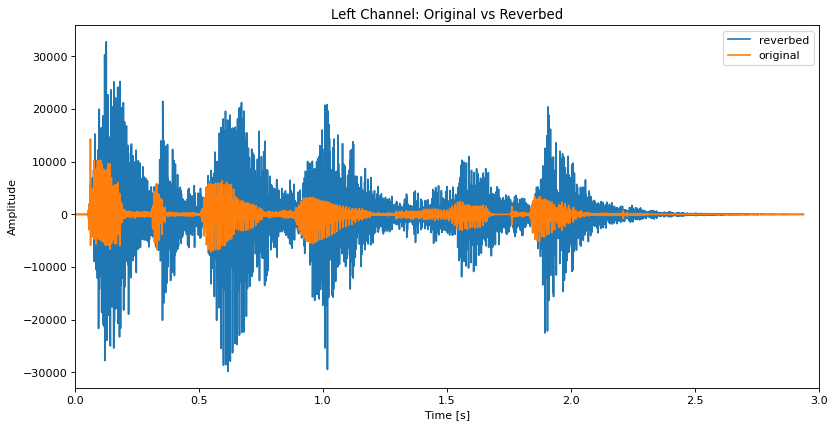

In [34]:
figure(figsize=(12, 6), dpi=80)
time = np.linspace(0., length, data.shape[0])
plt.plot(time, rv_data[:,0], label="reverbed")
plt.plot(time, data[:,0], label="original")
plt.xlim(0, 3)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Left Channel: Original vs Reverbed")
plt.show()

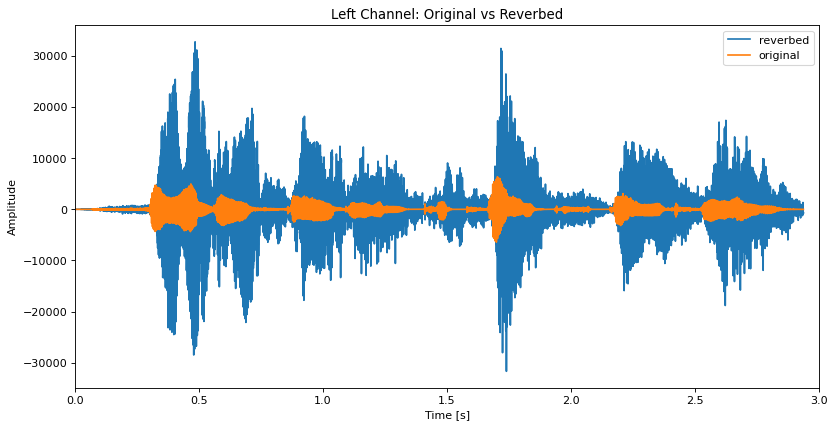

In [35]:
figure(figsize=(12, 6), dpi=80)
time = np.linspace(0., length, data.shape[0])
plt.plot(time, rv_data[:,1], label="reverbed")
plt.plot(time, data[:,1], label="original")
plt.xlim(0, 3)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Left Channel: Original vs Reverbed")
plt.show()